In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import requests
from io import BytesIO

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

train_df = pd.read_excel("/content/train(1).xlsx")
test_df = pd.read_excel("/content/test2.xlsx")
train_df.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [5]:
import os
os.listdir("/content")




['.config', 'train(1).xlsx', 'images', 'test2.xlsx', 'sample_data']

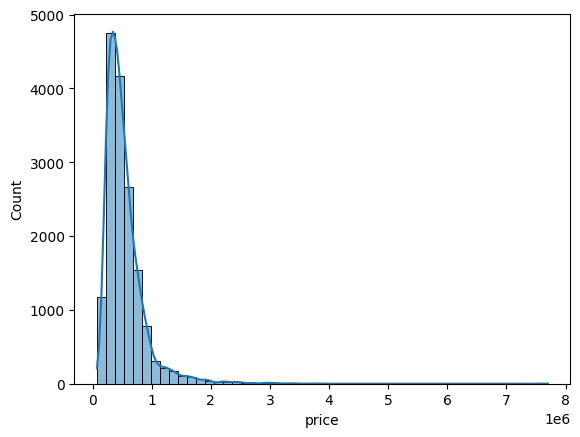

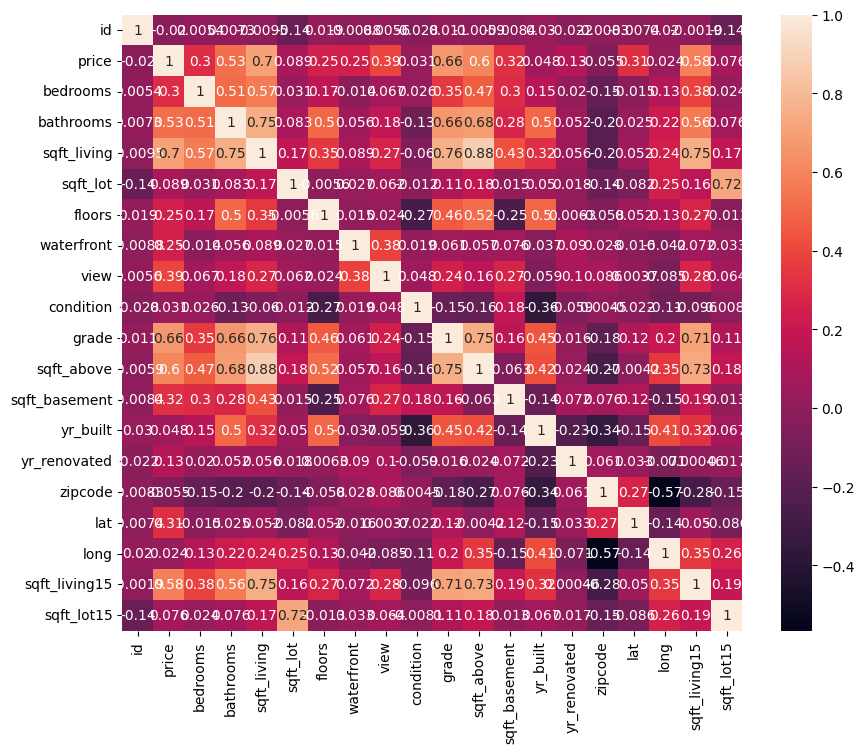

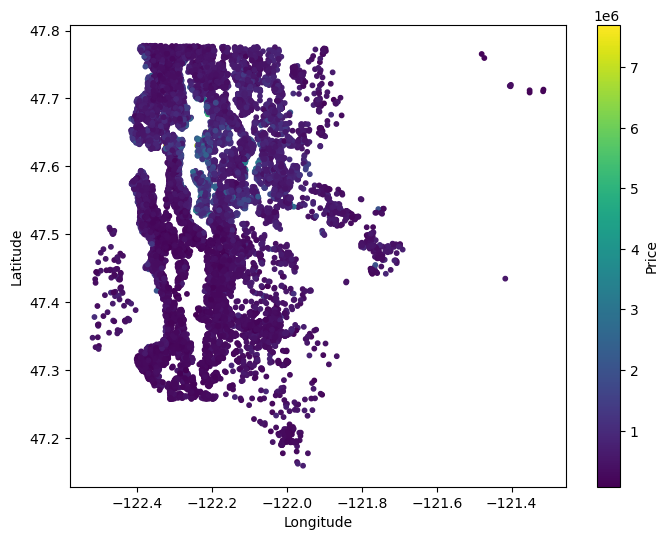

In [9]:
numeric_df = train_df.select_dtypes(include=np.number)

sns.histplot(numeric_df['price'], bins=50, kde=True)
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(numeric_df['long'], numeric_df['lat'], c=numeric_df['price'], cmap='viridis', s=10)
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [10]:
os.makedirs("/content/images/train", exist_ok=True)
os.makedirs("/content/images/test", exist_ok=True)


In [11]:
import requests
from PIL import Image
from io import BytesIO

MAPBOX_TOKEN = "pk.eyJ1IjoiYXJrYXByYXZhYmlzd2FzOTE5IiwiYSI6ImNtazFjazh5YTA0anEzcHF3aTBmMWRvbTUifQ.hiIJnRAGojipNCvi2uuDMg"

def fetch_image(lat, lon, path):
    url = (
        f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/"
        f"{lon},{lat},18/224x224"
        f"?access_token={MAPBOX_TOKEN}"
    )
    r = requests.get(url)
    if r.status_code == 200:
        img = Image.open(BytesIO(r.content)).convert("RGB")
        img.save(path)



In [12]:
import os

os.makedirs("images/train", exist_ok=True)


In [13]:
import time
import os

os.makedirs("images/train", exist_ok=True)

for i, row in train_df.head(500).iterrows():
    img_path = f"images/train/{i}.png"
    if not os.path.exists(img_path):
        fetch_image(row['lat'], row['long'], img_path)
        time.sleep(0.15)



In [14]:
import os, time

os.makedirs("images/train", exist_ok=True)

for i, row in train_df.head(500).iterrows():
    fetch_image(row["lat"], row["long"], f"images/train/{i}.png")
    time.sleep(0.15)




In [15]:
import os, time

os.makedirs("images/test", exist_ok=True)

for i, row in test_df.head(500).iterrows():
    fetch_image(
        row["lat"],
        row["long"],
        f"images/test/{i}.png"
    )
    time.sleep(0.1)




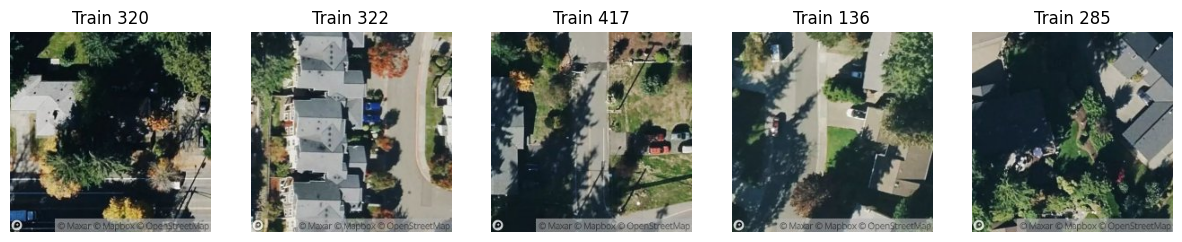

In [16]:
import random

idx = random.sample(range(500), 5)

plt.figure(figsize=(15,5))
for j, i in enumerate(idx):
    img = Image.open(f"images/train/{i}.png")
    plt.subplot(1,5,j+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Train {i}")
plt.show()



In [22]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
import torch
import torchvision.models as models

resnet = models.resnet18(pretrained=True)
resnet.eval()

resnet_embedding = torch.nn.Sequential(
    *list(resnet.children())[:-1]
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


In [23]:
train_size = 500
tabular_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                    'floors', 'waterfront', 'view', 'condition', 'grade']
tabular_train = train_df[tabular_features].head(train_size).values

image_embeddings_train = []

for i in range(train_size):
    img = Image.open(f"images/train/{i}.png")
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        emb = resnet_embedding(img_t).squeeze().numpy()
    image_embeddings_train.append(emb)

image_embeddings_train = np.array(image_embeddings_train)
X_train_combined = np.hstack([tabular_train, image_embeddings_train])
y_train = train_df['price'].head(train_size).values

print(X_train_combined.shape)
print(y_train.shape)


(500, 521)
(500,)


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)



In [25]:

from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)


Ridge()

In [26]:

y_train_pred = model.predict(X_train_scaled)
y_train_pred = np.maximum(y_train_pred, 0)


In [28]:
import os

n_test_images = len(os.listdir("images/test"))

image_embeddings_test = []

for i in range(n_test_images):
    img = Image.open(f"images/test/{i}.png").convert("RGB")
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        emb = resnet_embedding(img_t).squeeze().numpy()
    image_embeddings_test.append(emb)

image_embeddings_test = np.array(image_embeddings_test)
X_test_combined = np.hstack([tabular_test[:n_test_images], image_embeddings_test])
X_test_scaled = scaler.transform(X_test_combined)


In [29]:
test_preds = model.predict(X_test_scaled)
test_preds = np.maximum(test_preds, 0)



In [30]:
submission = pd.DataFrame({
    "id": test_df.index[:len(test_preds)],
    "price": test_preds
})

submission.to_csv("submission.csv", index=False)


In [32]:
submission.head()


,id,price
0,0,1.234819e+06
1,1,5.201504e+05
2,2,1.543767e+06
3,3,1.727186e+06
4,4,0.000000e+00


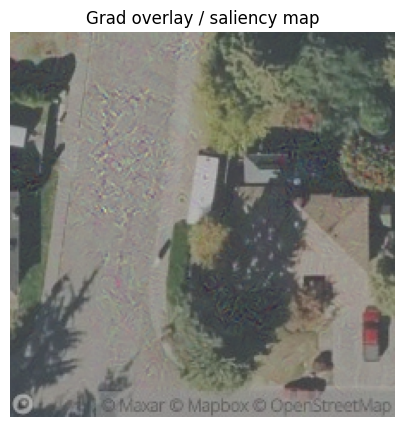

In [33]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open("images/test/0.png").convert("RGB")
img_t = transform(img).unsqueeze(0)
img_t.requires_grad = True

resnet_embedding.eval()
output = resnet_embedding(img_t)
target = output.sum()
target.backward()

grad = img_t.grad.data.squeeze().permute(1,2,0).numpy()
grad = (grad - grad.min()) / (grad.max() - grad.min())

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.imshow(grad, alpha=0.5, cmap='jet')
plt.axis('off')
plt.title("Grad overlay / saliency map")
plt.show()



In [34]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_train_pred = model.predict(X_train_scaled)
y_train_pred = np.maximum(y_train_pred, 0)

rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2 = r2_score(y_train, y_train_pred)

rmse, r2


(np.float64(37430.28301275936), 0.9846151609339651)